In [0]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [0]:
import json
import pandas as pd
import numpy as np
import os, os.path
import time
import csv

N_FACE = 70
N_POSE = 25
N_HAND = 21
FOLDER = '/content/drive/My Drive/636/data/json/'
CSV_FOLDER = '/content/drive/My Drive/636/dataset/'

Reshape Data into Segments and Prepare for Keras (part5 data)

In [0]:
dataset = pd.read_csv(CSV_FOLDER + 'dataset_pose_only.csv')

In [0]:
vid = dataset.vid.unique()

from sklearn.model_selection import train_test_split
X_train_vid, X_test_vid= train_test_split(vid, test_size=0.2, random_state=9)
print(X_train_vid.shape, X_test_vid.shape)

X_test_data = dataset.loc[dataset['vid'].isin(X_test_vid)]
X_test_data = X_test_data.reset_index()
X_test_data.drop(X_test_data.columns[[0]], axis=1, inplace=True)

X_train_data = dataset.loc[dataset['vid'].isin(X_train_vid)]
X_train_data = X_train_data.reset_index()
X_train_data.drop(X_train_data.columns[[0]], axis=1, inplace=True)

print(X_test_data.shape[0] / dataset.shape[0])
print(X_test_data.index[X_test_data['label'] == 1].shape[0] / X_test_data.index[X_test_data['label'] == 0].shape[0])

(417,) (105,)
0.20336965368123125
1.0045498084291187


In [0]:
print(X_train_data.shape, X_test_data.shape)

(65581, 53) (16742, 53)


In [0]:
# get number of features
# N_FEATURES = (N_FACE + N_POSE + N_HAND * 2) * 2
N_FEATURES = N_POSE * 2

In [0]:
N_FEATURES

50

In [0]:
# slice every TIME_STEP frame as a segment until from 1st frame to last, if null, make up with 0
def get_slices(df, index_arr, TIME_STEP):
  slices = []
  for i in index_arr:
    if i + 1 < TIME_STEP:
      slice_ = df.values[df.index[0 : i + 1]]
      fillzero = np.zeros((TIME_STEP - i - 1, N_FEATURES))
      slice_ = np.concatenate((slice_, fillzero), axis=0)
      slices.append(slice_)
    else:
      slices.append(df.values[df.index[i + 1 - TIME_STEP : i + 1]])

  slices_arr = np.asarray(slices, dtype= np.float32)
  return slices_arr

In [0]:
def create_segments(df, TIME_STEP):
  # get video id
  vids = df.vid.unique()
  segments = []
  # get segment of each video id
  for i in vids:
    # slice every 10 frame as a segment and use the first label as label of segment
    # get all index of an id
    index_arr = df.index[df['vid'] == i]
    # drop the id and label
    df_s = df[df.columns[3:]]

    if i == vids[0]:
      segments = get_slices(df_s, index_arr, TIME_STEP)
    else:
      # get slices of each person
      segment = get_slices(df_s, index_arr, TIME_STEP)
      # print(i, segment.shape)
      segments = np.concatenate((segments, segment), axis=0)

  return segments

In [0]:
y_train = X_train_data['label'].to_numpy()
y_test = X_test_data['label'].to_numpy()

In [0]:
X_train = create_segments(X_train_data, 15)
X_test = create_segments(X_test_data, 15)

In [0]:
# idx = np.random.permutation(y_train.shape[0])
# X_train, y_train = X_train[idx], y_train[idx]

In [0]:
# draw
import matplotlib.pyplot as plt
def draw(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'b', label='Training acc', color='red')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')

  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss', color='red')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

Build model

In [0]:
%tensorflow_version 1.x
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, LSTM, CuDNNLSTM, Dropout, Flatten, Bidirectional, Conv1D, MaxPooling1D, Activation
from keras.callbacks import History, EarlyStopping, ModelCheckpoint

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
# hyperparameter
TIME_STEP = 15
BATCH_SIZE = 64
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = N_FEATURES
# callbacks
# mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
# callbacks_list = [early_stop, mcp_save]
callbacks_list = [early_stop]
model_path = './drive/My Drive/636/model/'

Model 1

In [0]:
def create_model_1():
  model = Sequential()
  model.add(Dense(units = 32, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 32, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [0]:
# create model
model_1 = create_model_1()
history = model_1.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

NameError: ignored

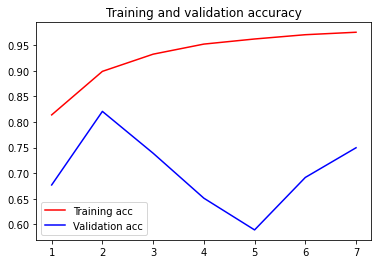

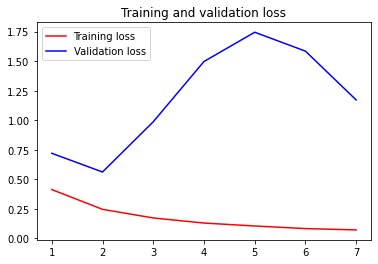

In [0]:
draw(history)

In [0]:
model_1.save(model_path + 'model1_8119.csv')

In [0]:
def create_model_1():
  model = Sequential()
  model.add(Dense(units = 64, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 64, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dropout(DROPOUT))

  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [0]:
# create model
model1_1 = create_model_1()
history = model1_1.fit(X_train, y_train, epochs=100, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model1_1.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

ModuleNotFoundError: ignored

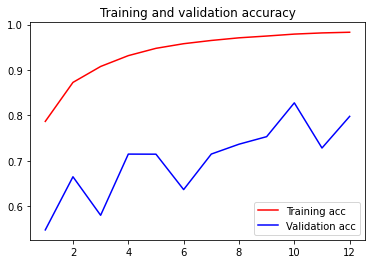

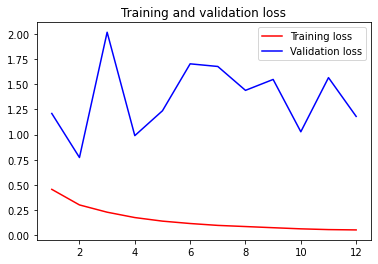

In [0]:
draw(history)

In [0]:
model1_1.save(model_path + 'model1_8225.csv')

In [0]:
# create model
model1_2 = create_model_1()
history = model1_2.fit(X_train, y_train, epochs=100, batch_size=64, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model1_2.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10, 64)            3264      
_________________________________________________________________
lstm_6 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 48,737
Trainable params: 48,737
Non-trainable params: 0
__________________________________________________

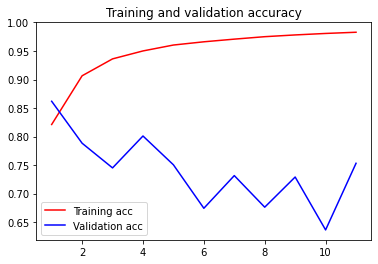

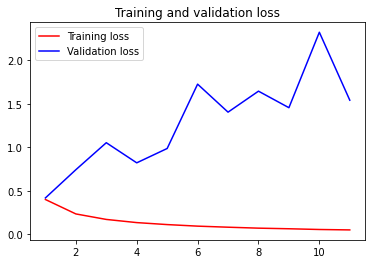

In [0]:
draw(history)

In [0]:
model1_2.save(model_path + 'model1_8251.csv')

In [0]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

def create_model_3():
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=128, kernel_size=4, activation='relu'), 
                            input_shape=(None, TIME_STEP, INPUT_DIM)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=4)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [0]:
# create model
model3 = create_model_3()
X_train_4 = X_train.reshape((X_train.shape[0], 1, TIME_STEP, INPUT_DIM))
history3 = model3.fit(X_train_4, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
X_test_4 = X_test.reshape((X_test.shape[0], 1, TIME_STEP, INPUT_DIM))
score3 = model3.evaluate(X_test_4, y_test, verbose=2)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 7, 128)      25728     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1, 128)      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 128)         0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 75,201
Trainable params: 75,201
Non-trainable params: 0
_________________________________________________

In [0]:
print("test loss: ", score3[0], "test acc: ", score3[1])

test loss:  1.1091367278208604 test acc:  0.8202641010284424


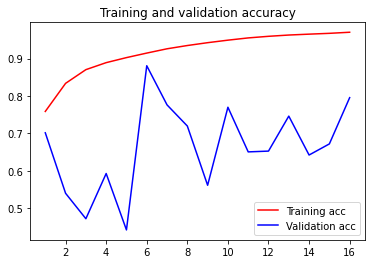

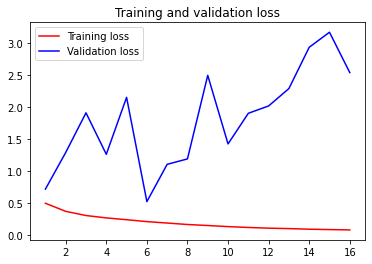

In [0]:
draw(history3)

In [0]:
model3.save(model_path + 'model3_8307.h5')

In [0]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

def create_model_4():
  model = Sequential()
  model.add(Dense(units = 64, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(LSTM(64, activation='relu', input_shape=(TIME_STEP, INPUT_DIM), 
                 return_sequences = True))
  model.add(Dropout(0.5))
  model.add(LSTM(32, activation='relu'))
  model.add(Dropout(0.5)) 
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]
model4 = create_model_4()
history4 = model4.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score4 = model4.evaluate(X_test, y_test)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 10, 64)            3264      
_________________________________________________________________
lstm_9 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 48,737
Trainable params: 48,737
Non-trainable params: 0
__________________________________________________

In [0]:
print("test loss: ", score4[0], "test acc: ", score4[1])

test loss:  17.795766396119305 test acc:  0.8119497895240784


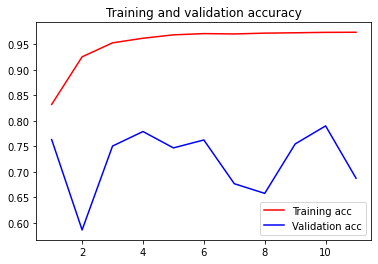

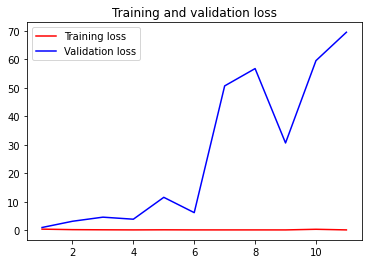

In [0]:
draw(history4)

In [0]:
def create_model_5():
  model = Sequential()
  model.add(Bidirectional(CuDNNLSTM(128, return_sequences = True)))
  model.add(Dropout(0.5))
  model.add(Bidirectional(CuDNNLSTM(64)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [0]:
model5 = create_model_5()
history5 = model5.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score5 = model5.evaluate(X_test, y_test, verbose=2)

Train on 100852 samples, validate on 25213 samples
Epoch 1/100
 - 19s - loss: 0.3304 - acc: 0.8505 - val_loss: 0.9901 - val_acc: 0.6031
Epoch 2/100
 - 17s - loss: 0.1914 - acc: 0.9227 - val_loss: 0.7860 - val_acc: 0.7521
Epoch 3/100
 - 17s - loss: 0.1382 - acc: 0.9468 - val_loss: 1.4661 - val_acc: 0.6543
Epoch 4/100
 - 17s - loss: 0.1095 - acc: 0.9590 - val_loss: 1.2337 - val_acc: 0.6936
Epoch 5/100
 - 17s - loss: 0.0911 - acc: 0.9662 - val_loss: 0.8472 - val_acc: 0.7934
Epoch 6/100
 - 17s - loss: 0.0787 - acc: 0.9716 - val_loss: 1.4038 - val_acc: 0.6993
Epoch 7/100
 - 17s - loss: 0.0705 - acc: 0.9748 - val_loss: 1.7339 - val_acc: 0.6685
Epoch 8/100
 - 17s - loss: 0.0637 - acc: 0.9771 - val_loss: 1.6530 - val_acc: 0.6821
Epoch 9/100
 - 17s - loss: 0.0584 - acc: 0.9794 - val_loss: 1.2712 - val_acc: 0.7495
Epoch 10/100
 - 17s - loss: 0.0554 - acc: 0.9809 - val_loss: 1.3932 - val_acc: 0.7614
Epoch 11/100
 - 17s - loss: 0.0510 - acc: 0.9828 - val_loss: 1.1683 - val_acc: 0.7727
Epoch 12/100

In [0]:
model5.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 10, 256)           413696    
_________________________________________________________________
dropout_14 (Dropout)         (None, 10, 256)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164864    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 578,689
Trainable params: 578,689
Non-trainable params: 0
_________________________________________________________________


In [0]:
score5

[0.8059523158893741, 0.8464210033416748]

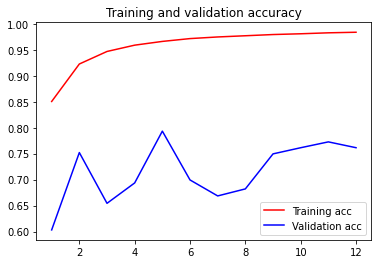

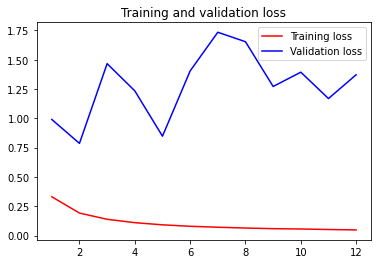

In [0]:
draw(history5)

In [0]:
model5.save(model_path + 'model5_8464.h5')

In [0]:
def create_model5_2():
  model = Sequential()
  model.add(Bidirectional(LSTM(64, return_sequences = True)))
  model.add(Dropout(0.5))
  model.add(Bidirectional(LSTM(64)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

Train on 100852 samples, validate on 25213 samples
Epoch 1/100
 - 80s - loss: 0.3330 - acc: 0.8509 - val_loss: 1.7344 - val_acc: 0.4069
Epoch 2/100
 - 76s - loss: 0.2009 - acc: 0.9187 - val_loss: 0.5767 - val_acc: 0.8167
Epoch 3/100
 - 76s - loss: 0.1507 - acc: 0.9418 - val_loss: 0.6442 - val_acc: 0.8134
Epoch 4/100
 - 77s - loss: 0.1192 - acc: 0.9551 - val_loss: 0.5095 - val_acc: 0.8669
Epoch 5/100
 - 78s - loss: 0.1009 - acc: 0.9628 - val_loss: 0.9738 - val_acc: 0.7680
Epoch 6/100
 - 76s - loss: 0.0847 - acc: 0.9693 - val_loss: 0.9641 - val_acc: 0.7736
Epoch 7/100
 - 78s - loss: 0.0753 - acc: 0.9729 - val_loss: 1.1735 - val_acc: 0.7505
Epoch 8/100
 - 76s - loss: 0.0690 - acc: 0.9756 - val_loss: 1.1189 - val_acc: 0.7853
Epoch 9/100
 - 77s - loss: 0.0633 - acc: 0.9783 - val_loss: 1.3626 - val_acc: 0.7595
Epoch 10/100
 - 76s - loss: 0.0588 - acc: 0.9792 - val_loss: 1.1878 - val_acc: 0.7722
Epoch 11/100
 - 77s - loss: 0.0546 - acc: 0.9811 - val_loss: 1.3729 - val_acc: 0.7547
Epoch 12/100

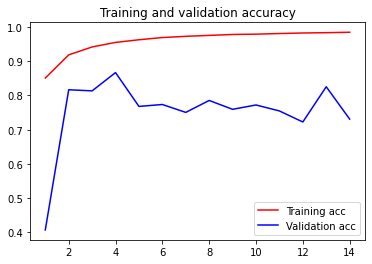

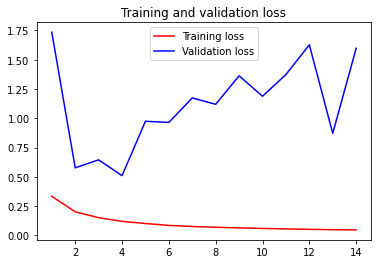

In [0]:
model5_2 = create_model5_2()
history5_2 = model5_2.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score5_2 = model5_2.evaluate(X_test, y_test, verbose=2)
print(score5_2)
draw(history5_2)

In [0]:
model5_2.save(model_path + 'model5_8274.h5')

In [0]:
def create_model_6():
  model = Sequential()
  model.add(Dense(units = 64, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 64, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32, return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [0]:
# create model
model6 = create_model_6()
history6 = model6.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score6 = model6.evaluate(X_test, y_test, verbose=2)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 10, 64)            17600     
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 10, 64)            33280     
_________________________________________________________________
dropout_18 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 10, 32)            12544     
_________________________________________________________________
dropout_19 (Dropout)         (None, 10, 32)            0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 32)                8448      
_________________________________________________________________
dense_18 (Dense)             (None, 1)               

In [0]:
score6

[0.9550316656210418, 0.8080479502677917]

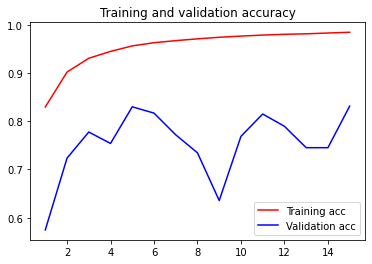

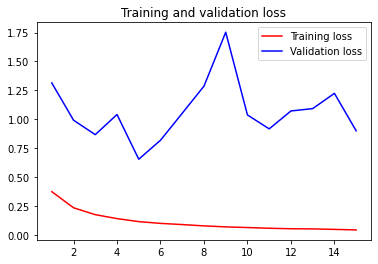

In [0]:
draw(history6)

In [0]:
model6.save(model_path + 'model6_8080.h5')

In [0]:
def create_model6_1():
  model = Sequential()
  model.add(Dense(units = 64, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 64, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32, return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dropout(DROPOUT))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [0]:
model6_1 = create_model_6()
history6_1 = model6_1.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score6_1 = model6_1.evaluate(X_test, y_test, verbose=2)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 10, 64)            17600     
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (None, 10, 64)            33280     
_________________________________________________________________
dropout_20 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 10, 32)            12544     
_________________________________________________________________
dropout_21 (Dropout)         (None, 10, 32)            0         
_________________________________________________________________
cu_dnnlstm_9 (CuDNNLSTM)     (None, 32)                8448      
_________________________________________________________________
dense_20 (Dense)             (None, 1)               

[0.748390522817301, 0.825194239616394]


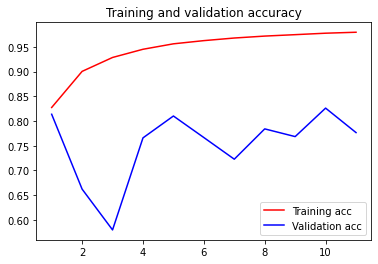

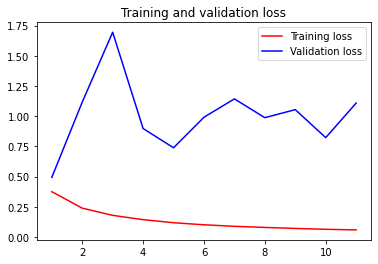

In [0]:
print(score6_1)
draw(history6_1)

In [0]:
model6_1.save(model_path + 'model6_1_8251.h5')

In [0]:
def create_model7():
  model = Sequential()
  model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu',
                    input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(MaxPooling1D(pool_size=4))
  model.add(CuDNNLSTM(64))
  model.add(Dropout(DROPOUT))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [0]:
model7 = create_model7()
history7 = model7.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score7 = model7.evaluate(X_test, y_test, verbose=2)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 10, 256)           350976    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2, 256)            0         
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 64)                82432     
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 433,473
Trainable params: 433,473
Non-trainable params: 0
_________________________________________________________________
Train on 107155 samples, validate on 18910 samples
Epoch 1/100
 - 9s - loss: 0.4043 - acc: 0.8129 - val_loss: 0.6

[0.7289786637429395, 0.8299257755279541]


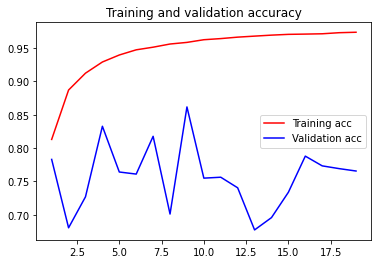

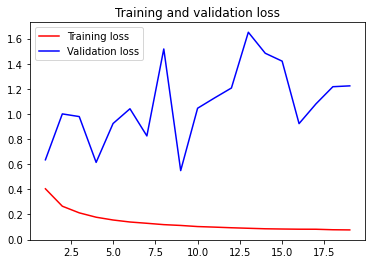

In [0]:
print(score7)
draw(history7)

In [0]:
model7.save(model_path +'model7_8299.h5')

In [0]:
def create_model7_1():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu',
                    input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(MaxPooling1D(pool_size=4))
  model.add(CuDNNLSTM(64))
  model.add(Dropout(DROPOUT))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 10, 128)           175488    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
cu_dnnlstm_11 (CuDNNLSTM)    (None, 64)                49664     
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 225,217
Trainable params: 225,217
Non-trainable params: 0
_________________________________________________________________
Train on 107155 samples, validate on 18910 samples
Epoch 1/100
 - 9s - loss: 0.4014 - acc: 0.8122 - val_loss: 0.9

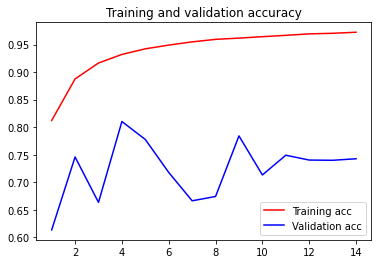

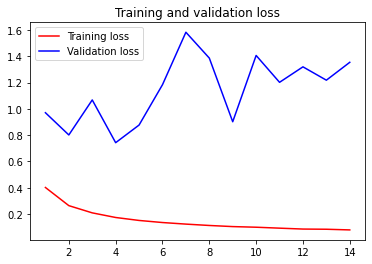

In [0]:
model7_1 = create_model7_1()
history7_1 = model7_1.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score7_1 = model7_1.evaluate(X_test, y_test, verbose=2)
print(score7_1)
draw(history7_1)

In [0]:
def create_model8():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu',
                    input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(MaxPooling1D(pool_size=4))
  model.add(CuDNNLSTM(64, return_sequences=True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(32))
  model.add(Dropout(DROPOUT))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 10, 128)           175488    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
cu_dnnlstm_12 (CuDNNLSTM)    (None, 2, 64)             49664     
_________________________________________________________________
dropout_24 (Dropout)         (None, 2, 64)             0         
_________________________________________________________________
cu_dnnlstm_13 (CuDNNLSTM)    (None, 32)                12544     
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

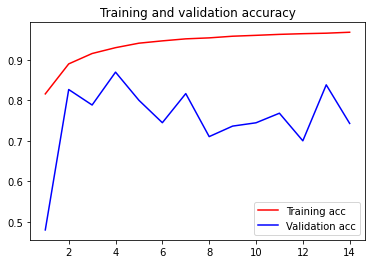

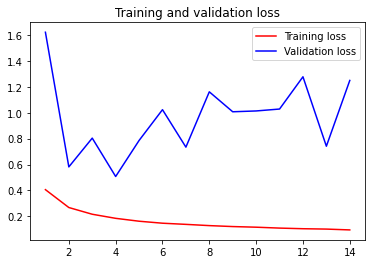

In [0]:
model8 = create_model8()
history8 = model8.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score8 = model8.evaluate(X_test, y_test, verbose=2)
print(score8)
draw(history8)

In [0]:
model8.save(model_path+'model8_8198.h5')

In [0]:
from keras.utils import np_utils
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, Activation, MaxPooling1D, Dropout, Dense, LSTM, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint

In [0]:
def create_model9():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=2, activation='relu', 
                   input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(BatchNormalization())
  model.add(Activation("relu"))

  model.add(LSTM(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 9, 128)            70272     
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 128)            512       
_________________________________________________________________
activation_1 (Activation)    (None, 9, 128)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 120,257
Trainable params: 120,001
Non-trainable params: 256
_____________________________________________

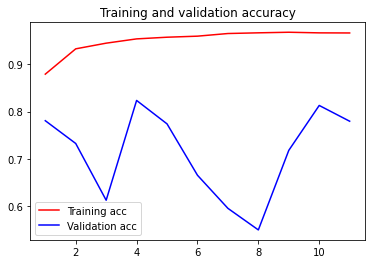

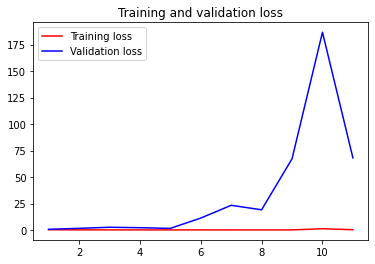

In [0]:
model9 = create_model9()
history9 = model9.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score9 = model9.evaluate(X_test, y_test, verbose=2)
print(score9)
draw(history9)

In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 128
EPOCH = 100
DROPOUT = 0.5

def create_model_10():
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                   input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 9, 64)             35136     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 50)                12850     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 51        
Total params: 48,037
Trainable params: 48,037
Non-trainable params: 0
_________________________________________________________________
Train on 107155 samples, validate on 18910 samples
Epoch 1/100
 - 5s - loss: 0.4084 - acc: 0.8105 - val_loss: 0.606

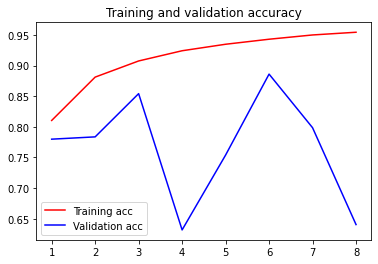

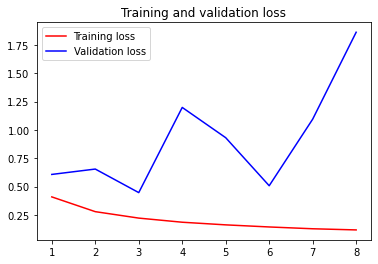

In [0]:
# create model
model10 = create_model_10()
history10 = model10.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score10 = model10.evaluate(X_test, y_test, verbose=2)
print(score10)
draw(history10)

In [0]:
model10.save(model_path + 'model10_8093.h5')

In [0]:
drop_list = ['rh_' + str(i) for i in range(30, 42)] + ['lh_' + str(i) for i in range(30, 42)]

In [0]:
X_train_data_4 = X_train_data.drop(columns=drop_list)

In [0]:
X_test_data_4 = X_test_data.drop(columns=drop_list)

In [0]:
N_FEATURES = 250
X_train_4 = create_segments(X_train_data_4, 10)
X_test_4 = create_segments(X_test_data_4, 10)

In [0]:
X_train_4 = X_train_4.reshape(X_train_4.shape[0], 50, 50, 1)
X_test_4 = X_test_4.reshape(X_test_4.shape[0], 50, 50, 1)

In [0]:
X_train_4.shape

(126065, 50, 50, 1)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
##designing the cnn
def create_model():
    #1st convolution layer
    model = Sequential()

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train_4.shape[1:])))
    model.add(Conv2D(64, kernel_size= (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.5))

    #2nd convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.5))

    #3rd convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

    model.add(Flatten())

    #fully connected neural networks
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))
    # model.summary()

    #Compliling the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model


In [0]:
model_dropout8 = create_model()
model_dropout8.summary()
history_dropout8 = model_dropout8.fit(X_train_4, y_train, epochs=50, batch_size=128, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score_dropout8 = model_dropout8.evaluate(X_test_4, y_test, verbose=2)
print(score_dropout8)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 19, 19, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 9, 64)        

In [0]:
model_dropout = create_model()
model_dropout.summary()
history_dropout = model_dropout.fit(X_train_4, y_train, epochs=50, batch_size=128, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 19, 19, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 9, 9, 64)        

In [0]:
score_dropout = model_dropout.evaluate(X_test_4, y_test, verbose=2)
print(score_dropout)

[0.7543250008985425, 0.8511090874671936]


In [0]:
model_dropout.save(model_path + 'model_dropout_8511.h5')

In [0]:
model_b = create_model()
model_b.summary()
history_b = model_b.fit(X_train_4, y_train, epochs=50, batch_size=64, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 19, 19, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 9, 9, 64)        

In [0]:
score_b = model_b.evaluate(X_test_4, y_test, verbose=2)
print(score_b)

[0.9702688392152429, 0.8499804735183716]


In [0]:
model_b.save(model_path + "model_b_8499.csv")

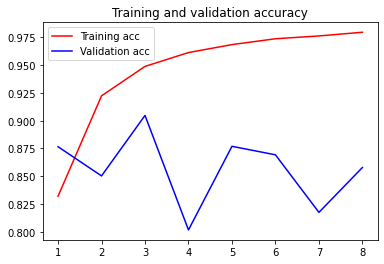

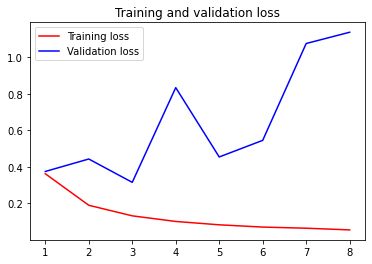

In [0]:
draw(history_b)

In [0]:
model_b = create_model()
model_b.summary()
history_b = model_b.fit(X_train_4, y_train, epochs=50, batch_size=256, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 19, 19, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 9, 9, 64)        

[0.5065342723439907, 0.8808438777923584]


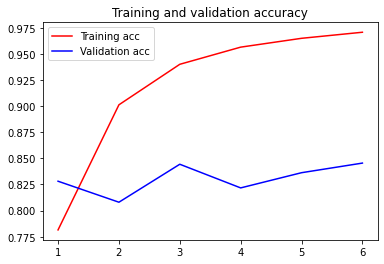

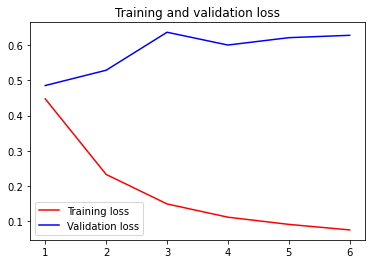

In [0]:
score_b = model_b.evaluate(X_test_4, y_test, verbose=2)
print(score_b)
draw(history_b)

In [0]:
model_b.save(model_path + 'model_b_8808.h5')

In [0]:
model = create_model()
history = model.fit(X_train_4, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model.evaluate(X_test_4, y_test, verbose=2)
print(score)

Train on 107155 samples, validate on 18910 samples
Epoch 1/100
 - 46s - loss: 0.3914 - acc: 0.8064 - val_loss: 0.9595 - val_acc: 0.6272
Epoch 2/100
 - 44s - loss: 0.2009 - acc: 0.9168 - val_loss: 0.5282 - val_acc: 0.7947
Epoch 3/100
 - 44s - loss: 0.1400 - acc: 0.9437 - val_loss: 0.9888 - val_acc: 0.7313
Epoch 4/100
 - 44s - loss: 0.1071 - acc: 0.9577 - val_loss: 1.0596 - val_acc: 0.6822
Epoch 5/100
 - 44s - loss: 0.0888 - acc: 0.9659 - val_loss: 1.3621 - val_acc: 0.7463
Epoch 6/100
 - 44s - loss: 0.0755 - acc: 0.9712 - val_loss: 1.2254 - val_acc: 0.7205
Epoch 7/100
 - 44s - loss: 0.0651 - acc: 0.9752 - val_loss: 1.6033 - val_acc: 0.7221
Epoch 00007: early stopping
[0.86157109192233, 0.8294916749000549]


In [0]:
model.save(model_path + "model_b_8294.h5")

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
##designing the cnn

def create_model_1(num_features):
    #1st convolution layer
    model = Sequential()

    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(X_train_4.shape[1:])))
    model.add(Conv2D(num_features,kernel_size= (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.5))

    # #2nd convolution layer
    # model.add(Conv2D(64, (3, 3), activation='relu'))
    # model.add(Conv2D(64, (3, 3), activation='relu'))
    # # model.add(BatchNormalization())
    # model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    # model.add(Dropout(0.5))

    #3rd convolution layer
    model.add(Conv2D(num_features * 4, (3, 3), activation='relu'))
    model.add(Conv2D(num_features * 4, (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())

    #fully connected neural networks
    model.add(Dense(num_features * 16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_features * 16, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))
    # model.summary()

    #Compliling the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model


Train on 109404 samples, validate on 19307 samples
Epoch 1/100
 - 32s - loss: 0.7083 - acc: 0.5536 - val_loss: 0.6782 - val_acc: 0.5565
Epoch 2/100
 - 31s - loss: 0.6750 - acc: 0.5657 - val_loss: 0.6746 - val_acc: 0.5623
Epoch 3/100
 - 31s - loss: 0.6713 - acc: 0.5706 - val_loss: 0.6691 - val_acc: 0.5694
Epoch 4/100
 - 31s - loss: 0.6681 - acc: 0.5771 - val_loss: 0.6398 - val_acc: 0.6152
Epoch 5/100
 - 31s - loss: 0.5755 - acc: 0.7025 - val_loss: 0.5458 - val_acc: 0.7294
Epoch 6/100
 - 31s - loss: 0.5593 - acc: 0.7174 - val_loss: 0.5292 - val_acc: 0.7373
Epoch 7/100
 - 31s - loss: 0.5549 - acc: 0.7272 - val_loss: 0.5131 - val_acc: 0.7461
Epoch 8/100
 - 31s - loss: 0.5279 - acc: 0.7323 - val_loss: 0.5085 - val_acc: 0.7502
Epoch 9/100
 - 31s - loss: 0.5128 - acc: 0.7390 - val_loss: 0.4919 - val_acc: 0.7513
Epoch 10/100
 - 31s - loss: 0.4989 - acc: 0.7443 - val_loss: 0.4898 - val_acc: 0.7533
Epoch 11/100
 - 31s - loss: 0.4788 - acc: 0.7622 - val_loss: 0.4790 - val_acc: 0.7799
Epoch 12/100

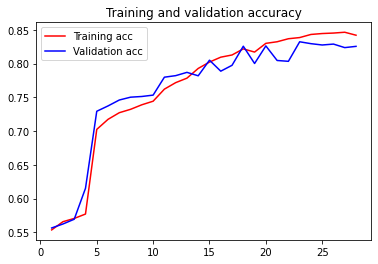

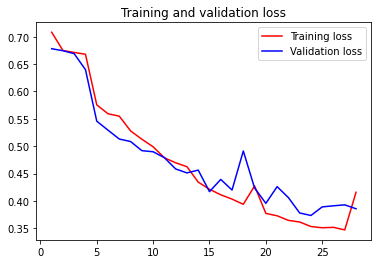

In [0]:
model_1 = create_model_1(50)
history_1 = model_1.fit(X_train_4, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score_1 = model_1.evaluate(X_test_4, y_test, verbose=2)
print(score_1)
draw(history_1)

In [0]:
from keras.layers import SpatialDropout2D
from keras import regularizers

def create_model_4():
    model=Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(X_train_4.shape[1:])))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(0.5))


    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(SpatialDropout2D(0.5))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',kernel_regularizer=regularizers.l2(0.09)))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',kernel_regularizer=regularizers.l2(0.09)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(0.5))
    model.add(Flatten())

    model.add(Dense(256,activation = 'relu',kernel_regularizer=regularizers.l2(0.09)))
    model.add(BatchNormalization())
    model.add(Dropout(0.7))
    model.add(Dense(256,activation = 'relu',kernel_regularizer=regularizers.l2(0.09)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1,activation = 'sigmoid'))
    #Compliling the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model


Train on 109404 samples, validate on 19307 samples
Epoch 1/100
 - 69s - loss: 4.5149 - acc: 0.5328 - val_loss: 0.8937 - val_acc: 0.5444
Epoch 2/100
 - 66s - loss: 0.8660 - acc: 0.6056 - val_loss: 0.9539 - val_acc: 0.5852
Epoch 3/100
 - 66s - loss: 0.8468 - acc: 0.6843 - val_loss: 0.8228 - val_acc: 0.7122
Epoch 4/100
 - 66s - loss: 0.8060 - acc: 0.7084 - val_loss: 0.7898 - val_acc: 0.7311
Epoch 5/100
 - 66s - loss: 0.7695 - acc: 0.7318 - val_loss: 0.7171 - val_acc: 0.7666
Epoch 6/100
 - 66s - loss: 0.7209 - acc: 0.7510 - val_loss: 0.7468 - val_acc: 0.7840
Epoch 7/100
 - 66s - loss: 0.6823 - acc: 0.7672 - val_loss: 0.6318 - val_acc: 0.8141
Epoch 8/100
 - 66s - loss: 0.6527 - acc: 0.7840 - val_loss: 0.6159 - val_acc: 0.8166
Epoch 9/100
 - 66s - loss: 0.6251 - acc: 0.7955 - val_loss: 0.5504 - val_acc: 0.8370
Epoch 10/100
 - 66s - loss: 0.6087 - acc: 0.8065 - val_loss: 0.5345 - val_acc: 0.8506
Epoch 11/100
 - 66s - loss: 0.5924 - acc: 0.8176 - val_loss: 0.5113 - val_acc: 0.8588
Epoch 12/100

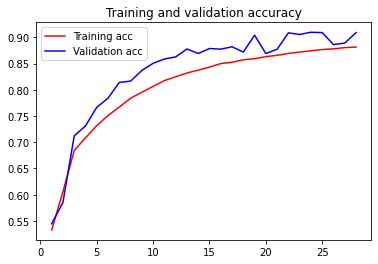

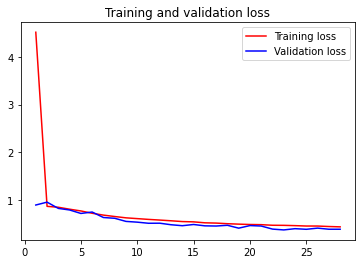

In [0]:
model_4 = create_model_4()
history_4 = model_4.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score_4 = model_4.evaluate(X_test, y_test, verbose=2)
print(score_4)
draw(history_4)

In [0]:
model_4.save(model_path + 'big_6189.h5')